# Analysing the performance of LEAF-X-OUT

## Imports

In [2]:
import os
os.chdir("../../")

In [75]:
import copy
import glob
import math
import yaml

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from cids.util import misc_funcs as misc
from cids.data import SCVIC_CIDS_CLASSES, SCVIC_CIDS_CLASSES_INV

In [15]:
def load_configs(paths, base=True):
    configs = {}
    for path in paths:
        with open(path, "r") as f:
            print(f"Loading {path}")
            config = yaml.safe_load(f)
        key = "model_type" if base else "id"
        configs[config["experiment"][key]] = config
    return configs


baseline_config_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/baseline/*.yaml"))
cids_config_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leaf-x-out/CIDS/*.yaml"))
cids_config_binary_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leave-x-out-binary/CIDS/*.yaml"))
mlp_config_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leaf-x-out/MLP/*.yaml"))
mlp_config_binary_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leave-x-out-binary/MLP/*.yaml"))
rf_config_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leaf-x-out/RF/*.yaml"))

unsupervised_config_paths = glob.glob(os.path.join(misc.root(), "config/02_anomaly_detection/baseline/*.yaml"))
unsupervised_leave_config_paths = glob.glob(os.path.join(misc.root(), "config/02_anomaly_detection/leave-x-out/MLPAE-2/*.yaml"))

baseline_configs = load_configs(baseline_config_paths, base=True)
cids_configs = load_configs(cids_config_paths, base=False)
cids_binary_configs = load_configs(cids_config_binary_paths, base=False)
mlp_configs = load_configs(mlp_config_paths, base=False)
mlp_binary_configs = load_configs(mlp_config_binary_paths, base=False)
rf_configs = load_configs(rf_config_paths, base=False)
unsupervised_configs = load_configs(unsupervised_config_paths, base=True)
unsupervised_leave_configs = load_configs(unsupervised_leave_config_paths, base=False)

Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline/MLP.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline/CIDS.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leaf-x-out/CIDS/LESS.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leaf-x-out/CIDS/BOT.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leaf-x-out/CIDS/FTP.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leaf-x-out/CIDS/DDoS.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leaf-x-out/CIDS/DoSDDoS.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leaf-x-out/CIDS/SSH.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/LESS.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-b

## Load Confusion-Matrixes

In [16]:
def load_confusion(key, config, base_path, binary=False, source="test"):
    confusion_matrix = np.zeros((len(config["experiment"]["seed"]), len(SCVIC_CIDS_CLASSES), 2 if binary else len(SCVIC_CIDS_CLASSES)))
    experiment_config = config["experiment"]
    for j in range(len(config["experiment"]["seed"])):
        confusion_matrix_seed = pd.read_csv(os.path.join(base_path, f"{experiment_config["id"]}-{j}/{source}_confusion.csv"), index_col=0, header=0)
        confusion_matrix[j] = confusion_matrix_seed.to_numpy()
    
    return confusion_matrix

In [76]:
mlp_confusion_matrices = {}
mlp_binary_confusion_matrices = {}
cids_confusion_matrices = {}
cids_binary_confusion_matrices = {}
base_confusion_matrices = {}
rf_confusion_matrices = {}
unsupervised_confusion_matrices = {}
unsupervised_leave_confusion_matrices = {}

source = "test" # One of train | val | test
for k, config in baseline_configs.items():
    experiment_config = config["experiment"]
    base_confusion_matrices[k] = load_confusion(k, config, base_path = os.path.join(misc.root(), f"results/01_supervision/baseline/{experiment_config["model_type"]}/{experiment_config["id"]}/"), source=source)
for k, config in mlp_configs.items():
    experiment_config = config["experiment"]
    mlp_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out/{experiment_config["model_type"]}/{experiment_config["id"]}/"), source=source)
for k, config in cids_configs.items():
    experiment_config = config["experiment"]
    cids_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out/{experiment_config["model_type"]}/{experiment_config["id"]}/"), source=source)
for k, config in mlp_binary_configs.items():
    experiment_config = config["experiment"]
    mlp_binary_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out-binary/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in cids_binary_configs.items():
    experiment_config = config["experiment"]
    cids_binary_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out-binary/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in rf_configs.items():
    experiment_config = config["experiment"]
    rf_confusion_matrices[k] = load_confusion(k, config, base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out/{experiment_config["model_type"]}/{experiment_config["id"]}/"), source=source)
for k, config in unsupervised_configs.items():
    experiment_config = config["experiment"]
    unsupervised_confusion_matrices[k] = load_confusion(k, config, base_path = os.path.join(misc.root(), f"results/02_anomaly-detection/baseline/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in unsupervised_leave_configs.items():
    experiment_config = config["experiment"]
    unsupervised_leave_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/02_anomaly-detection/leave-x-out/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)

base_confusion_probabilities = {}
for k, confusion in base_confusion_matrices.items():
    base_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)
    
mlp_confusion_probabilities = {}
for k, confusion in mlp_confusion_matrices.items():
    mlp_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

cids_confusion_probabilities = {}
for k, confusion in cids_confusion_matrices.items():
    cids_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

mlp_binary_confusion_probabilities = {}
for k, confusion in mlp_binary_confusion_matrices.items():
    mlp_binary_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

cids_binary_confusion_probabilities = {}
for k, confusion in cids_binary_confusion_matrices.items():
    cids_binary_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

rf_confusion_probabilities = {}
for k, confusion in rf_confusion_matrices.items():
    rf_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

unsupervised_confusion_probabilities = {}
for k, confusion in unsupervised_confusion_matrices.items():
    unsupervised_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

unsupervised_leave_confusion_probabilities = {}
for k, confusion in unsupervised_leave_confusion_matrices.items():
    unsupervised_leave_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)


## Functions

In [28]:
def plot_confusion_matrixies(confusion_matrices, labels=list(SCVIC_CIDS_CLASSES.keys())):
    rows = math.ceil(len(confusion_matrices) / 3)
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(confusion_matrices):
            ax.axis('off')
            continue
        key = list(confusion_matrices.keys())[i]
        cax = ax.matshow(confusion_matrices[key], cmap='YlOrRd')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Trial {key}')
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        ax.set_yticklabels(labels)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrixies_binary(confusion_matrices, labels=list(SCVIC_CIDS_CLASSES.keys())):
    rows = math.ceil(len(confusion_matrices) / 3)
    fig, axes = plt.subplots(rows, 3, figsize=(9, rows * 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(confusion_matrices):
            ax.axis('off')
            continue
        key = list(confusion_matrices.keys())[i]
        cax = ax.matshow(confusion_matrices[key], cmap='YlOrRd')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Trial {key}')
        ax.set_xticks(np.arange(2))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(["Benign", "Malicious"], rotation=90)
        ax.set_yticklabels(labels)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout()
    plt.show()


In [19]:
def calculate_accuracy_benign(confusion_matrices, exclude_classes, benign_class=0):
    accuracies = []
    for i in range(confusion_matrices.shape[0]):
        total = confusion_matrices[i, exclude_classes].sum()
        as_benign = confusion_matrices[i, exclude_classes, benign_class].sum()
        accuracy = (total - as_benign) / total
        accuracies.append(accuracy)
    return accuracies

def plot_boxplot_accuracies_leaf_out(confusion_matrices, configs, benign_class=0):
    accuracies = []
    labels = []
    for (k, v) in confusion_matrices.items():
        config = configs[k]
        exclude_classes = [SCVIC_CIDS_CLASSES[cls] for cls in config['dataset']['exclude']]
        accuracy = calculate_accuracy_benign(v, exclude_classes, benign_class)
        accuracies.append(accuracy)
        labels.append(f"Exclude {', '.join(map(str, exclude_classes))}")

    plt.figure(figsize=(10, 6))
    plt.boxplot(accuracies, tick_labels=labels)
    plt.xlabel('Left-out Classes')
    plt.ylabel('Accuracy')
    plt.title(f'Classification of left-out-classes as malicious for {config["experiment"]["model_type"]}')
    plt.xticks(rotation=45)
    # Add a textbox on the right of the plot that shows the SCVIC dict
    textstr = '\n'.join([f'{k}: {v}' for k, v in SCVIC_CIDS_CLASSES_INV.items()])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gcf().text(0.95, 0.5, textstr, fontsize=12, verticalalignment='center', bbox=props)
    plt.show()

In [ ]:
def calculate_accuracy(confusion, reduction=None):
    total_correct = np.trace(confusion, axis1=-2, axis2=-1)
    total_samples = np.sum(confusion, axis=(-2,-1))
    total_accuracy = total_correct / total_samples

    if reduction == "mean":
        return total_accuracy.mean()
    if reduction == "sum":
        return total_accuracy.sum()
    return total_accuracy

def calculate_f1(confusion, reduction=None):
    true_positives = np.diagonal(confusion, axis1=-2, axis2=-1)
    false_positives = np.sum(confusion, axis=-2) - true_positives
    false_negatives = np.sum(confusion, axis=-1) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_scores = 2 * (precision * recall) / (precision + recall)

    if reduction == "mean":
        return np.nanmean(f1_scores)
    if reduction == "sum":
        return np.nansum(f1_scores)
    return f1_scores

def classwise_f1_binary(confusion):
    tp = confusion[:, 1:, 1]
    fp = confusion[:, 0, 1][:, None]
    fn = confusion[:, 1:, 0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return 2 * (precision * recall) / (precision + recall + 1e-16)

def boxplot_metric(confusion_matrices: dict[str: np.ndarray], metric=calculate_accuracy, labels=list(SCVIC_CIDS_CLASSES.keys())[1:]):
    total_metric = {}
    classwise_metric = {key: {} for key in confusion_matrices.keys()}

    for key, matrix in confusion_matrices.items():

        total_matrix = np.zeros((matrix.shape[0], 2, 2))
        total_matrix[:, 0, :] = matrix[:, 0, :]
        total_matrix[:, 1, :] = np.sum(matrix[:, 1:, :], axis=1)

        total_metric[key] = np.squeeze(metric(confusion=total_matrix))
        class_wise = metric(confusion=matrix)
        num_classes = len(labels)
        for cls in range(num_classes):
            
            classwise_metric[key][labels[cls]] = class_wise[:, cls]
    avg_scores = {cls: np.mean([classwise_metric[key][cls] for key in confusion_matrices.keys()]) for cls in labels}
    textstr = '\n'.join([f'{cls}: {avg_scores[cls]:.2f}' for cls in labels])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gcf().text(0.95, 0.5, textstr, fontsize=12, verticalalignment='center', bbox=props)
    plt.figure(figsize=(12, 6))
    plt.boxplot([total_metric[key] for key in confusion_matrices.keys()], tick_labels=confusion_matrices.keys())
    plt.xlabel('Metric')
    plt.title('Total Metric')
    plt.show()

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    for i, key in enumerate(confusion_matrices.keys()):
        ax = axes[i]
        ax.boxplot([classwise_metric[key][cls] for cls in labels], tick_labels=labels)
        ax.set_xlabel('Metric')
        ax.set_title(f'Classwise Metric for {key}')
    
    for ax in axes:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
    plt.tight_layout()
    plt.show()


In [83]:
def remove_rows(matrices, remove, avg=True):
    rm = {k: np.delete(v, remove, axis=1) for k, v in matrices.items()}
    rm = {k: np.delete(v, remove, axis=2) for k, v in rm.items()}
    if avg:
        return {k: v.mean(axis=0) for k, v in rm.items()}
    return rm

def remove_rows_binary(matrices, remove, avg=True):
    rm = {k: np.delete(v, remove, axis=1) for k, v in matrices.items()}
    if avg:
        return {k: v.mean(axis=0) for k, v in rm.items()}
    return rm

## Evaluate Multiclass

### Baseline - Evaluation

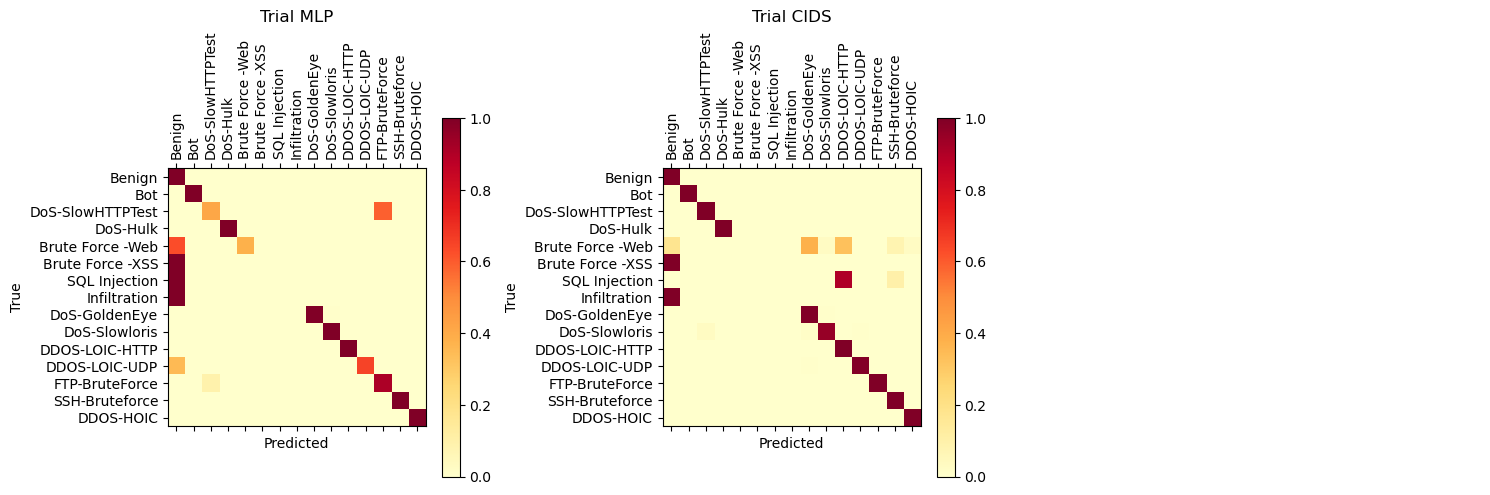

In [ ]:
average_base_confusion_matrix = {k: v.mean(axis=0) for k, v in base_confusion_probabilities.items()}

plot_confusion_matrixies(average_base_confusion_matrix)

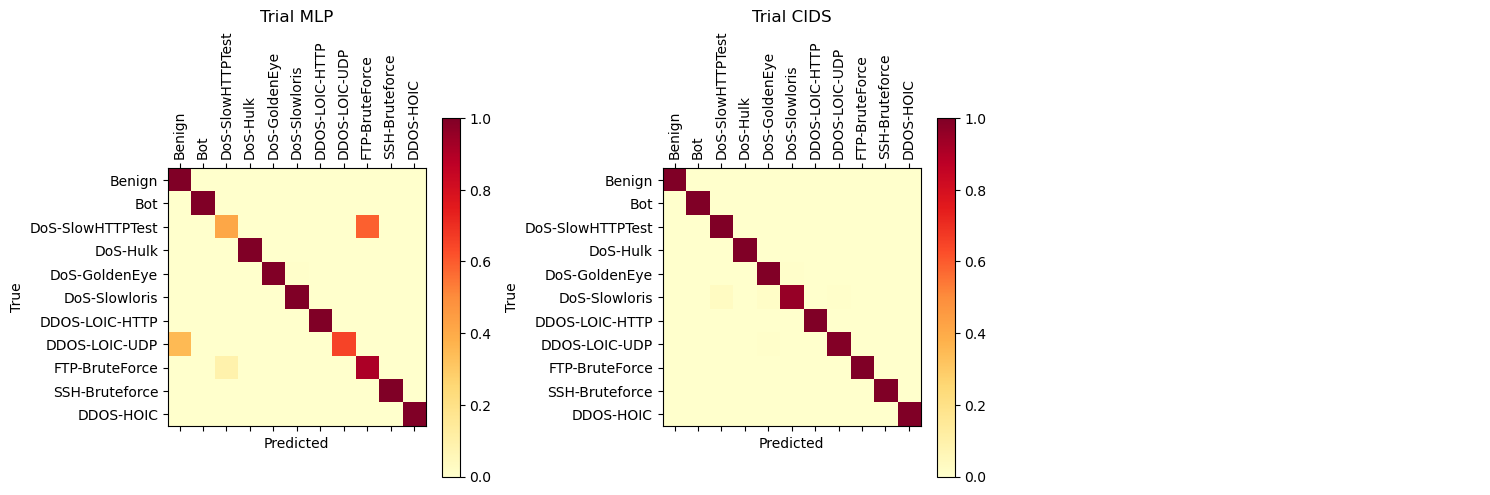

In [11]:
remove = [4, 5, 6,7]
remove_avg_base_confusion_matrix = remove_rows(base_confusion_probabilities, remove, avg=True)
plot_confusion_matrixies(remove_avg_base_confusion_matrix, labels=[SCVIC_CIDS_CLASSES_INV[i] for i in range(len(SCVIC_CIDS_CLASSES)) if i not in remove])

[0.98362275 0.98352504 0.98354676 0.9834979  0.9835359  0.98352504
 0.98322649 0.98354133 0.98316677 0.98354133]
[0.99953859 0.99928889 0.99946802 0.99962545 0.99951688 0.99953859
 0.99911518 0.99965802 0.99953316 0.99948431]


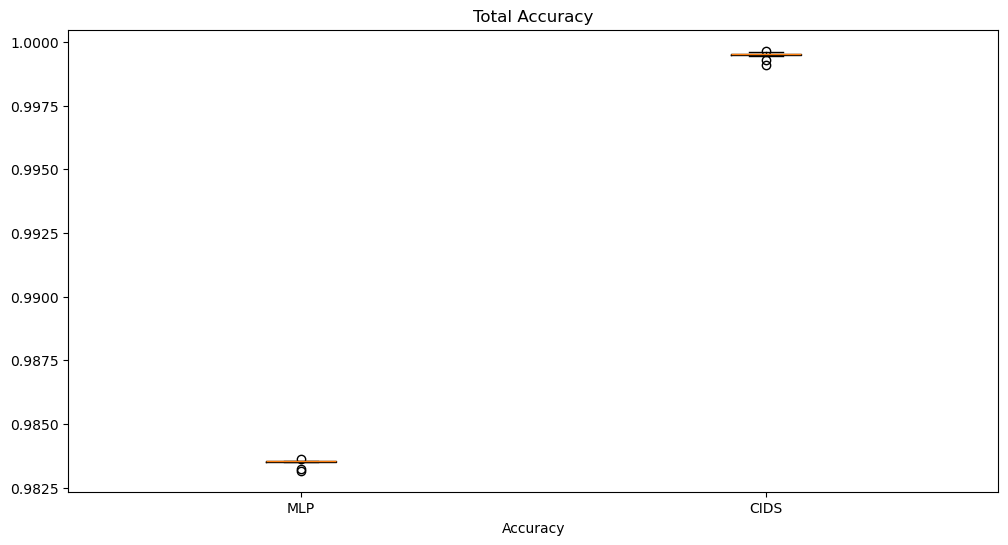

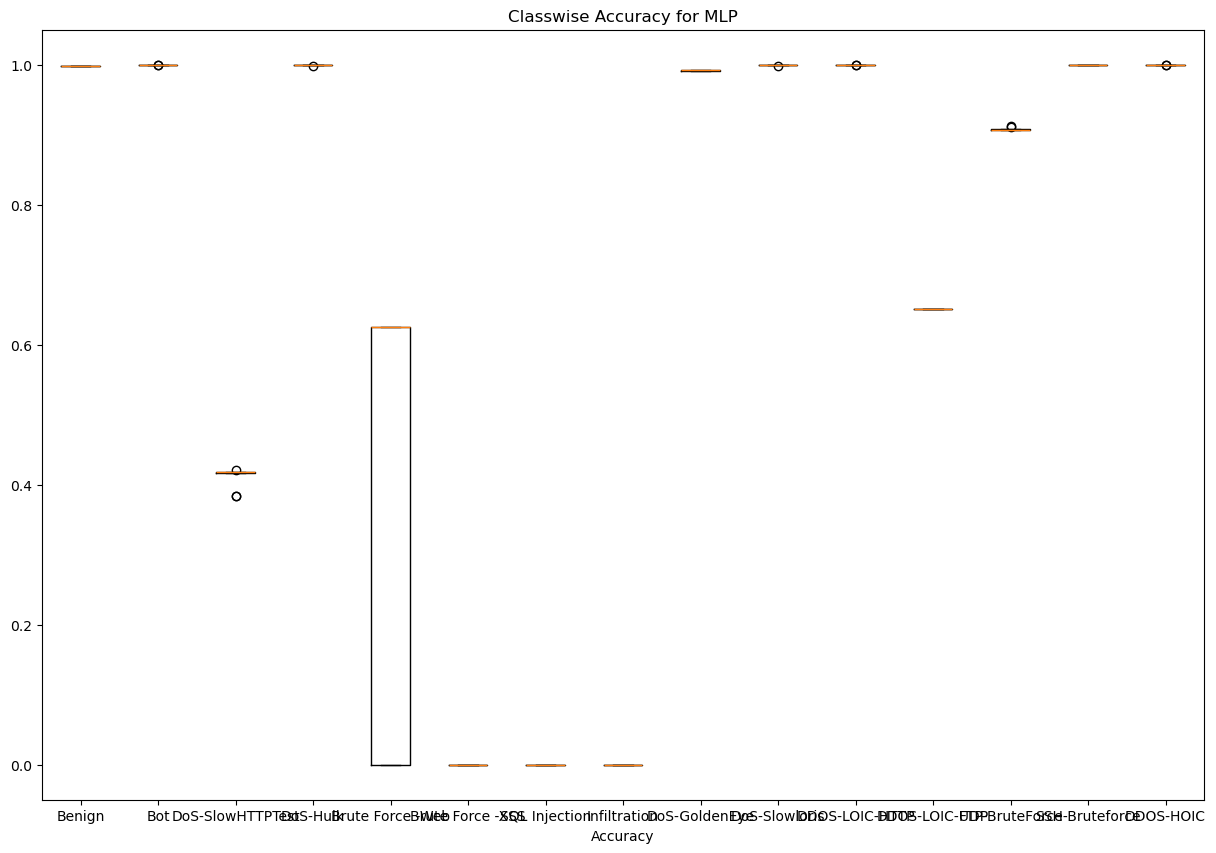

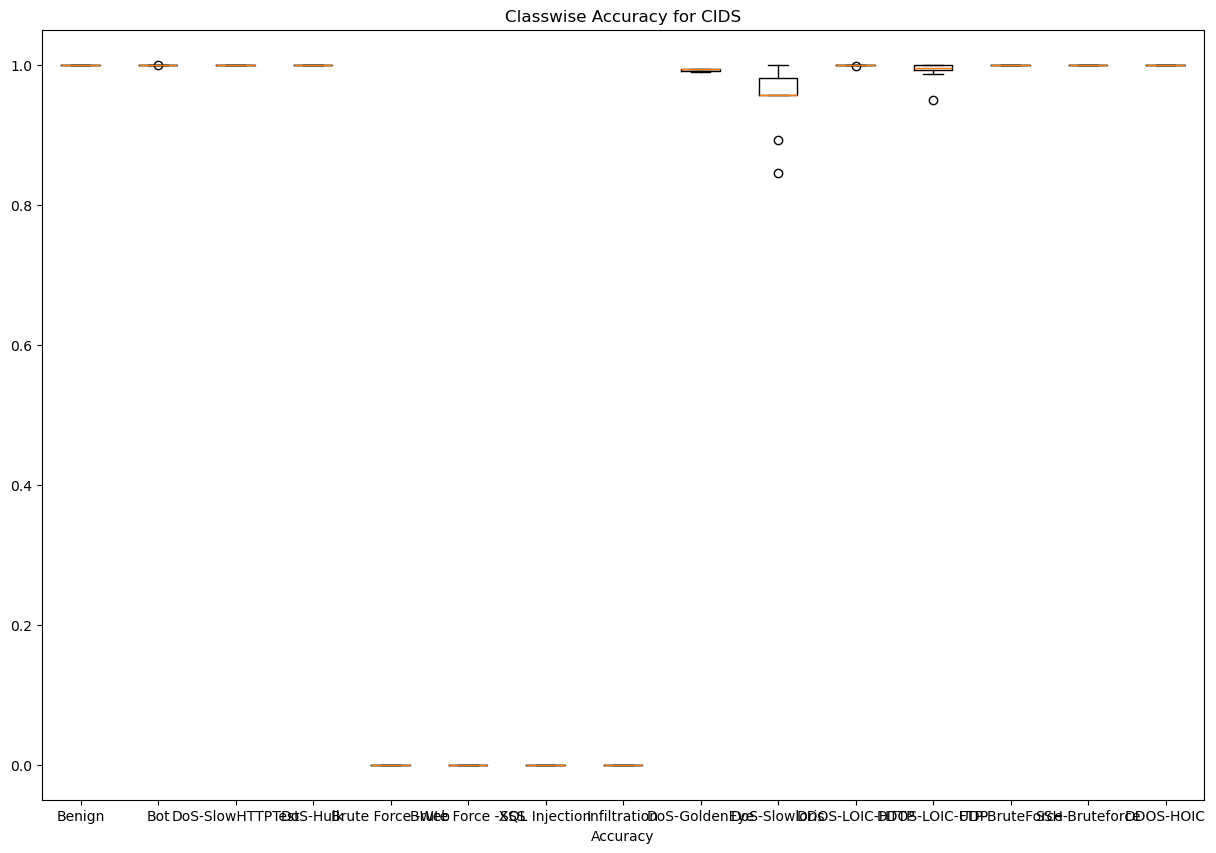

In [ ]:
boxplot_metric(base_confusion_matrices, metric="acc")

### Plot Average Matrix as heatmap

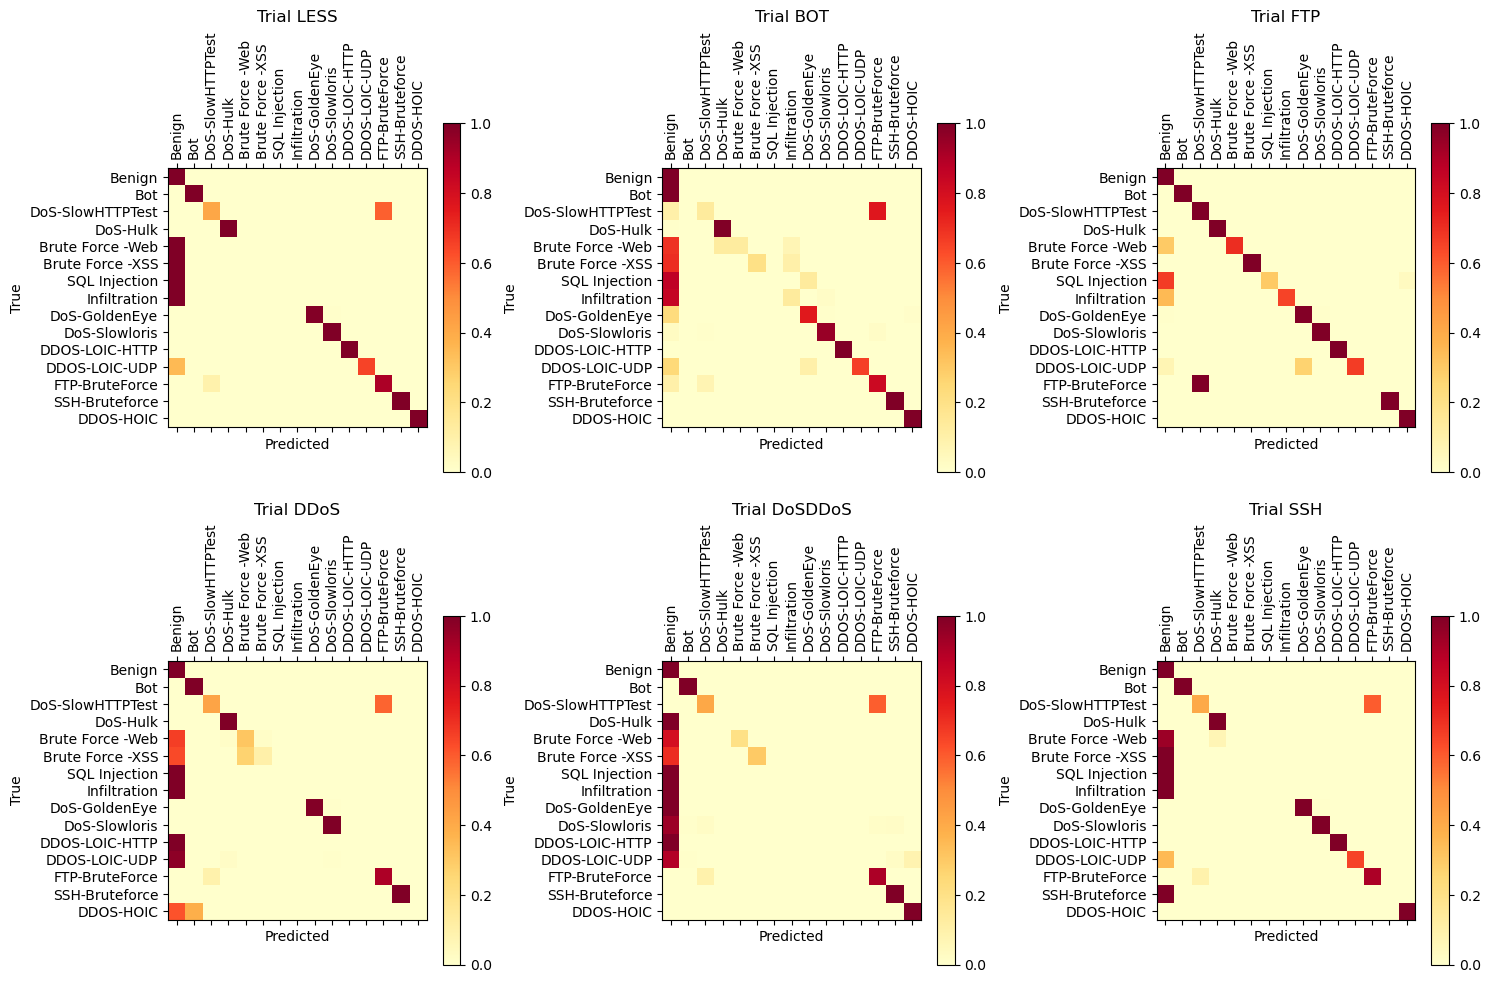

In [85]:
average_mlp_confusion_matrix = {k: v.mean(axis=0) for k, v in mlp_confusion_probabilities.items()}
plot_confusion_matrixies(average_mlp_confusion_matrix)

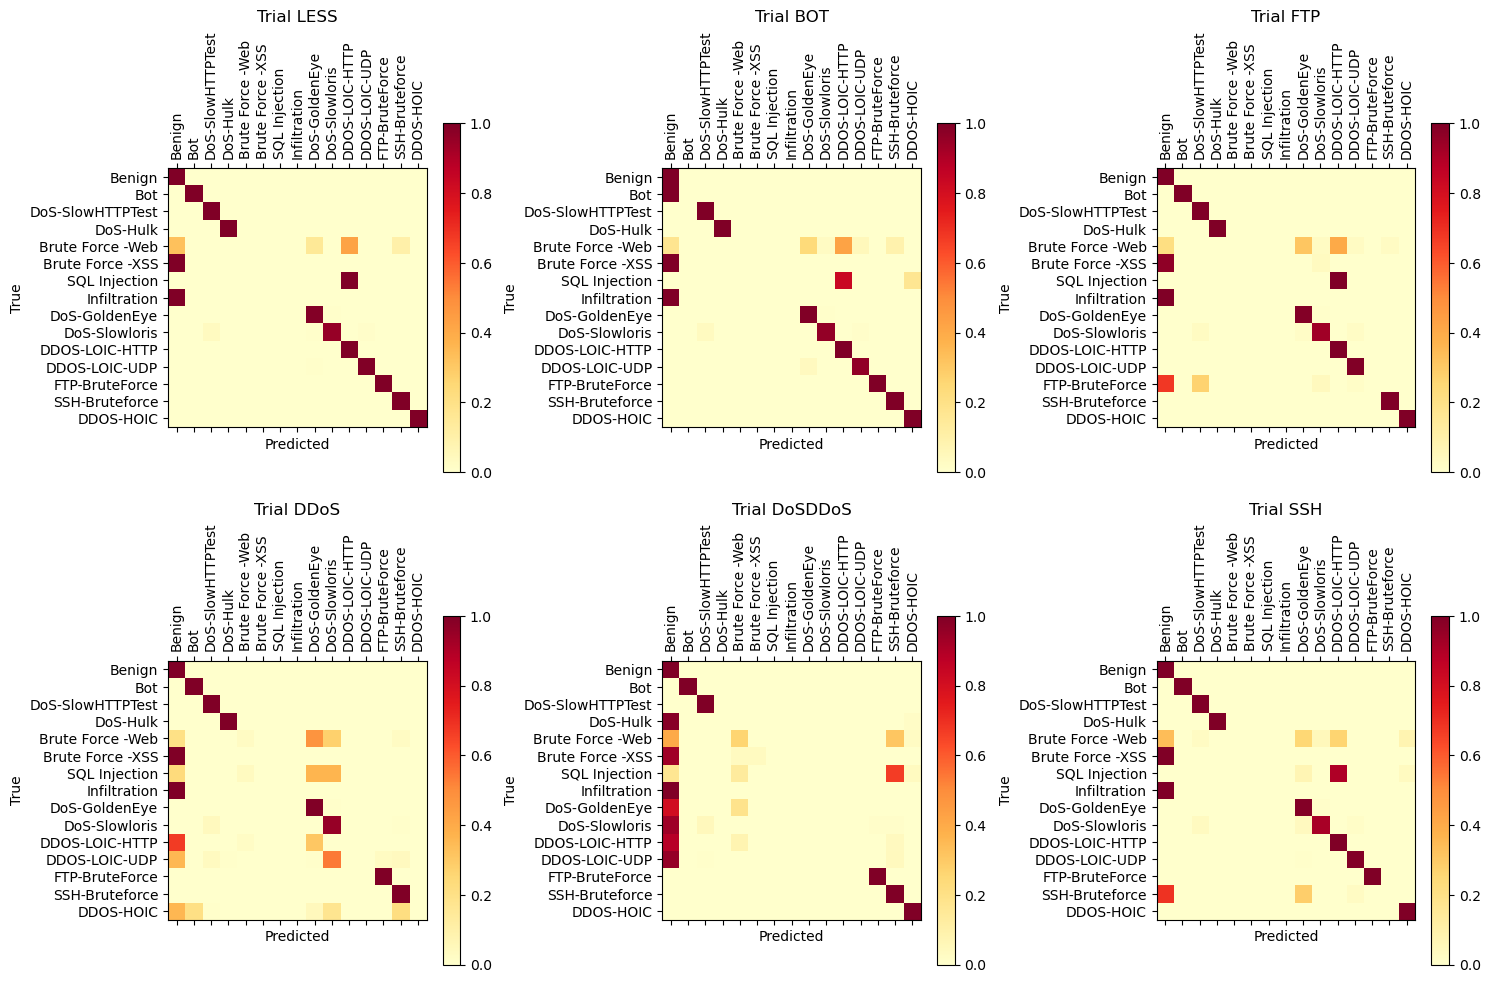

In [86]:

average_cids_confusion_matrix = {k: v.mean(axis=0) for k, v in cids_confusion_probabilities.items()}
plot_confusion_matrixies(average_cids_confusion_matrix)

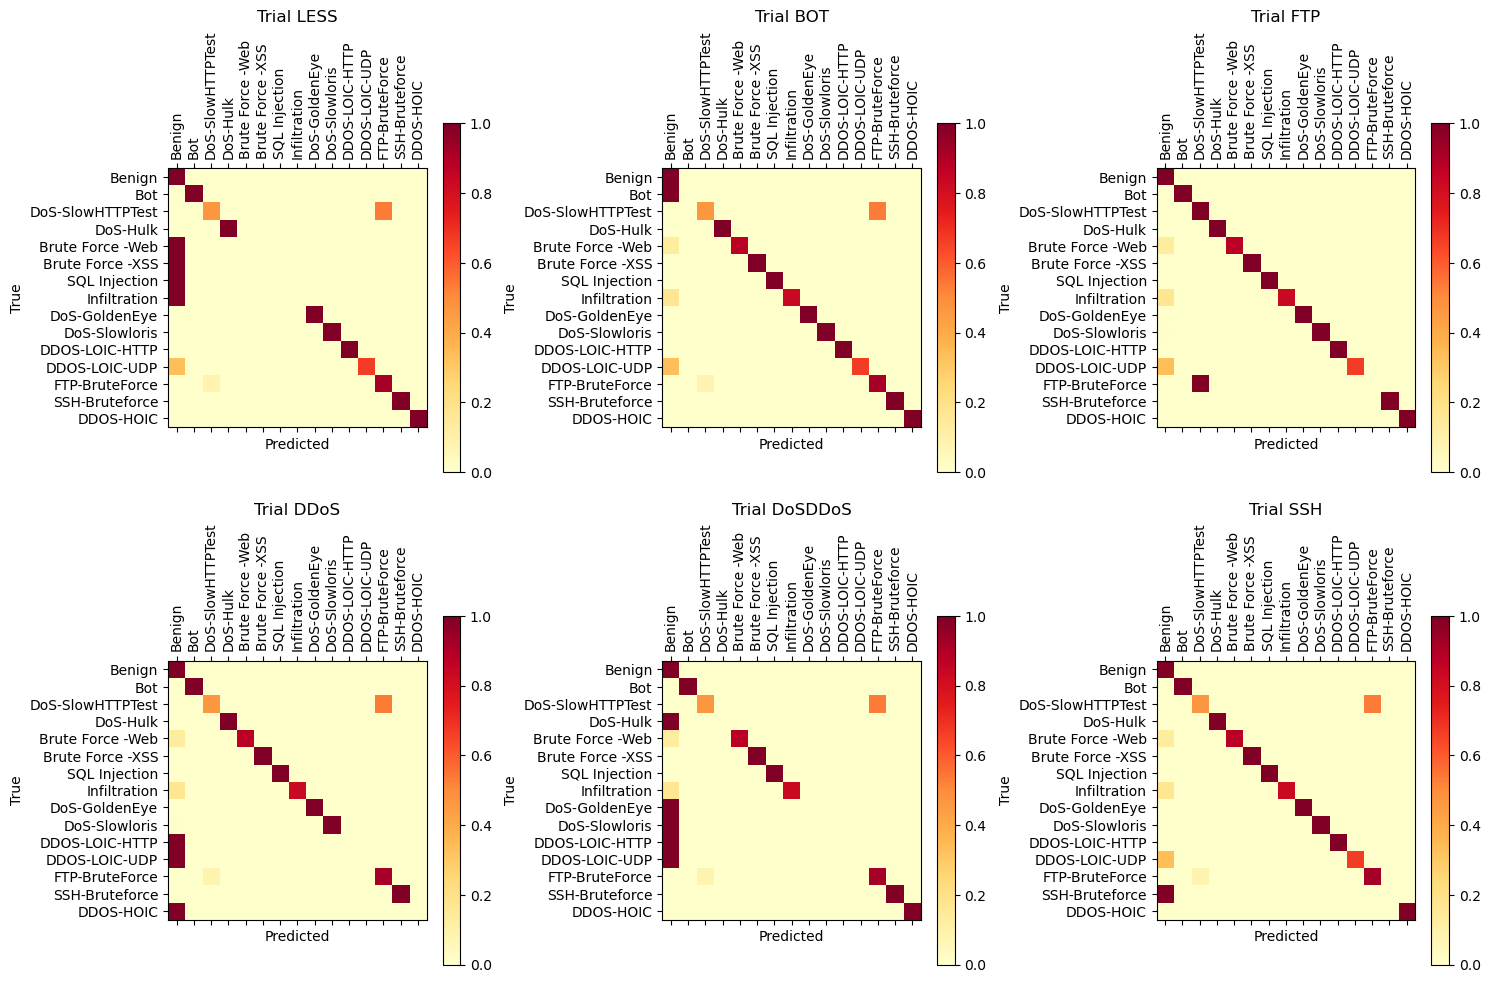

In [10]:
average_rf_confusion_matrix = {k: v.mean(axis=0) for k, v in rf_confusion_probabilities.items()}
plot_confusion_matrixies(average_rf_confusion_matrix)

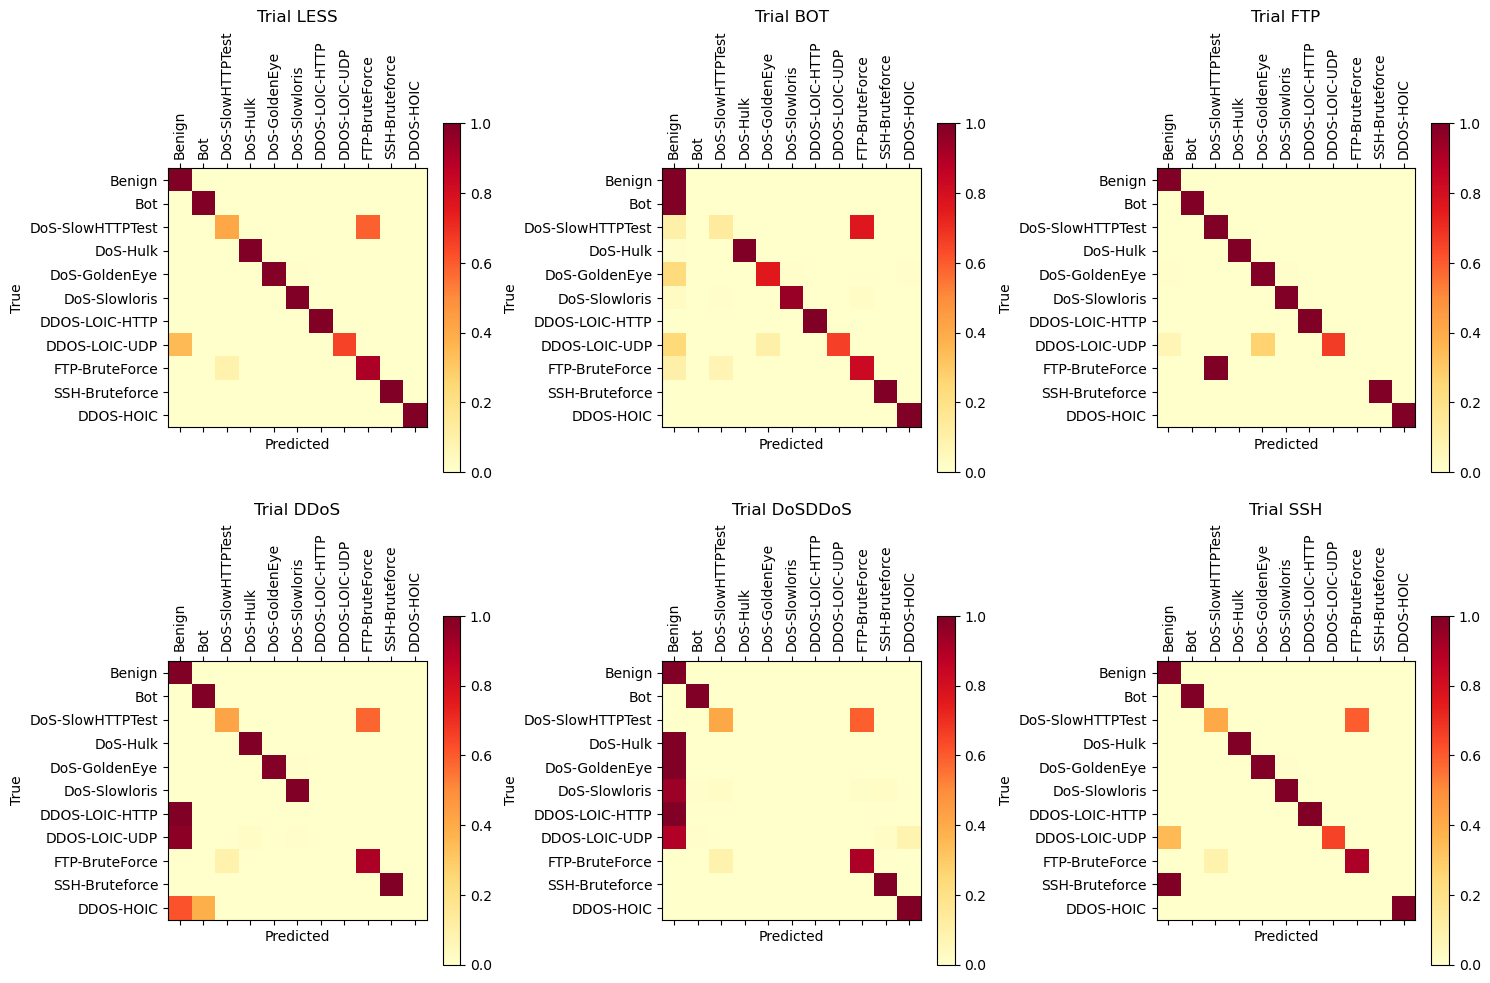

In [88]:
remove = [4, 5, 6,7]
average_rm_mlp_confusion_matrix = remove_rows(mlp_confusion_probabilities, remove, avg=True)
plot_confusion_matrixies(average_rm_mlp_confusion_matrix,
                          labels=[SCVIC_CIDS_CLASSES_INV[i] for i in range(len(SCVIC_CIDS_CLASSES)) if i not in remove])


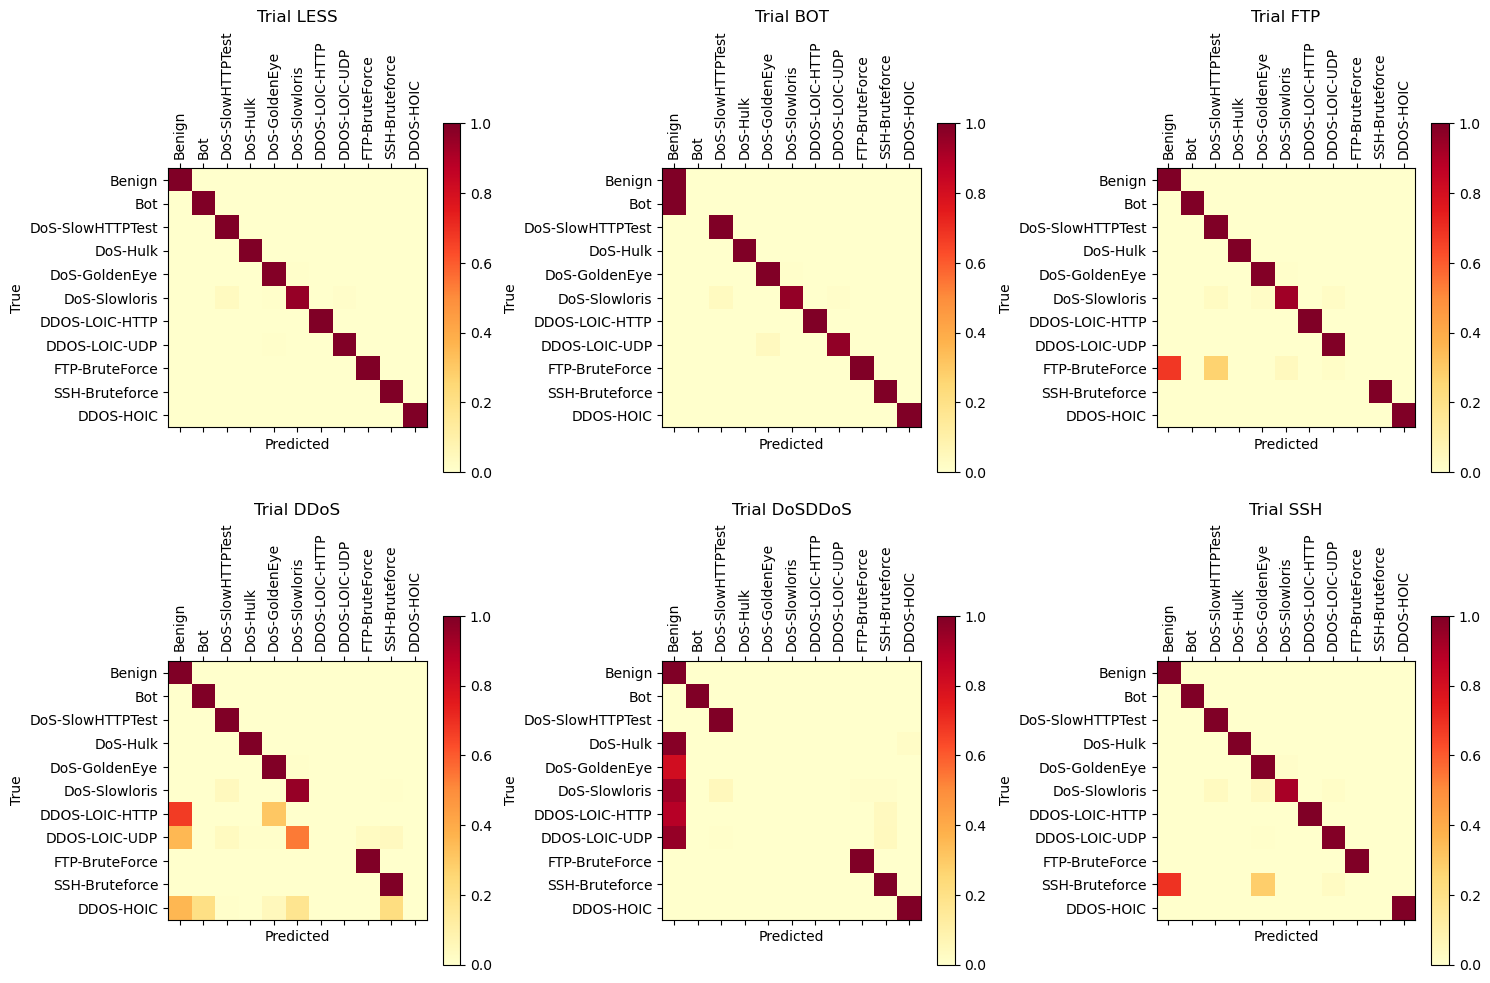

In [89]:
remove = [4, 5, 6,7]
average_rm_cids_confusion_matrix = remove_rows(cids_confusion_probabilities, remove, avg=True)
plot_confusion_matrixies(average_rm_cids_confusion_matrix,
                          labels=[SCVIC_CIDS_CLASSES_INV[i] for i in range(len(SCVIC_CIDS_CLASSES)) if i not in remove])

### Plot Classification Accuracy Benign | Malicious

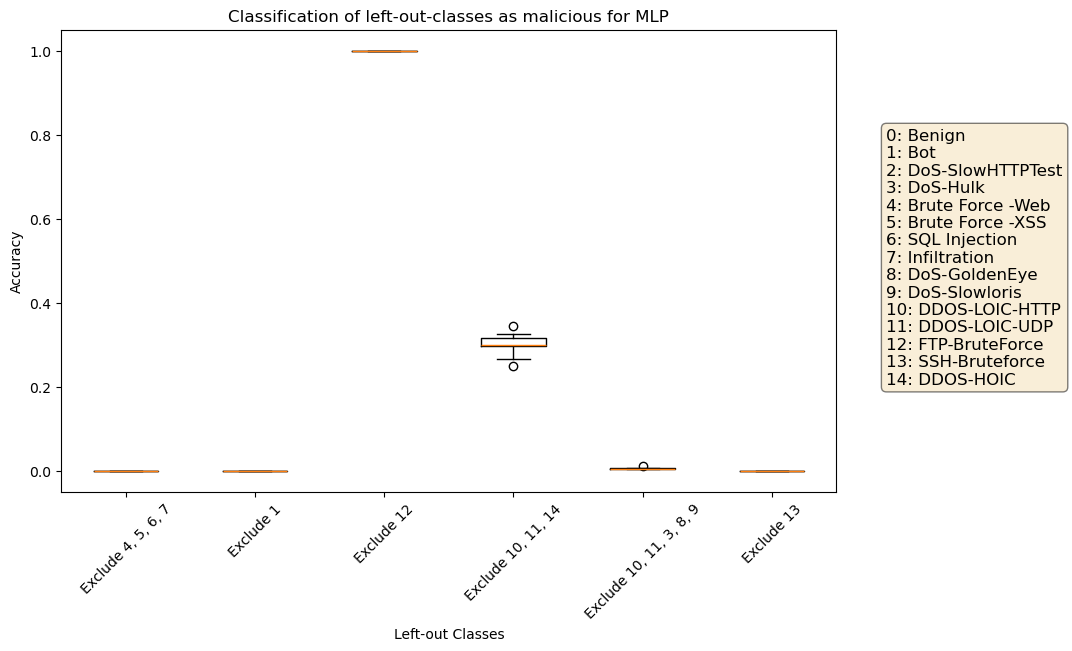

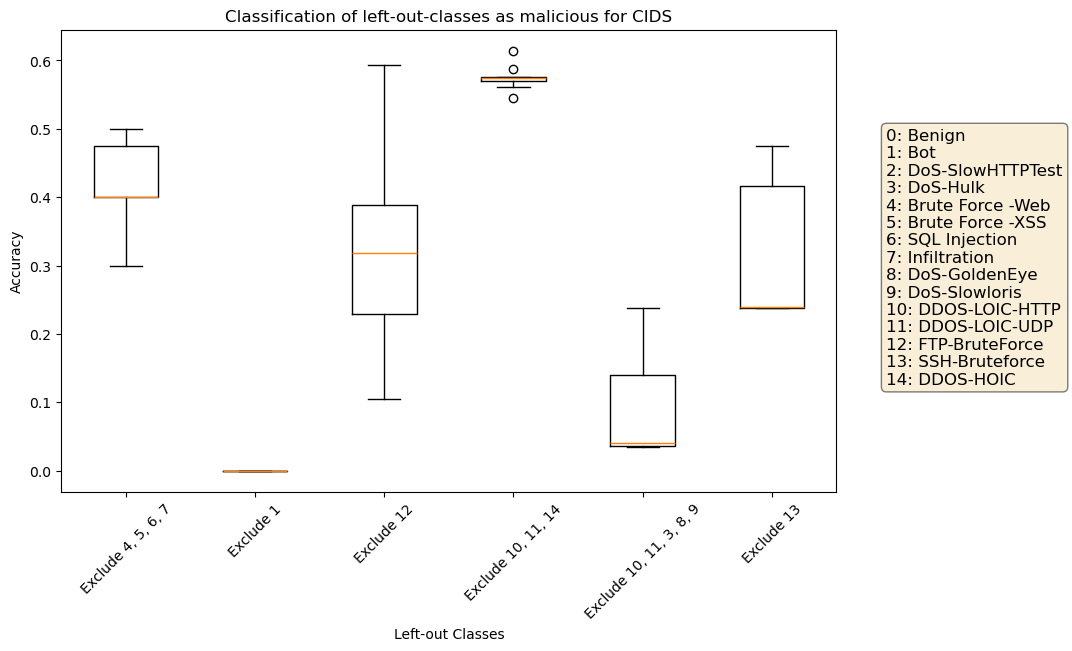

In [ ]:
plot_boxplot_accuracies_leaf_out(mlp_confusion_matrices, mlp_configs, 0)
plot_boxplot_accuracies_leaf_out(cids_confusion_matrices, cids_configs, 0)

## Evaluate Binary

### Baseline

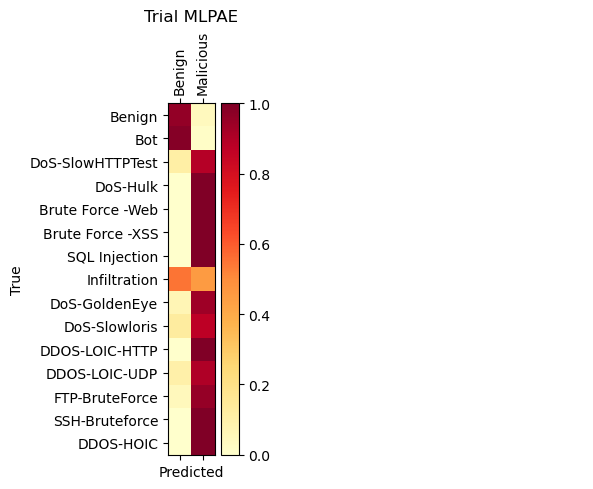

In [25]:
average_base_confusion_matrix = {k: v.mean(axis=0) for k, v in unsupervised_confusion_probabilities.items()}

plot_confusion_matrixies_binary(average_base_confusion_matrix)

In [ ]:
# F1-Scores of different models in binary

### Confusion Matrix Leave One out

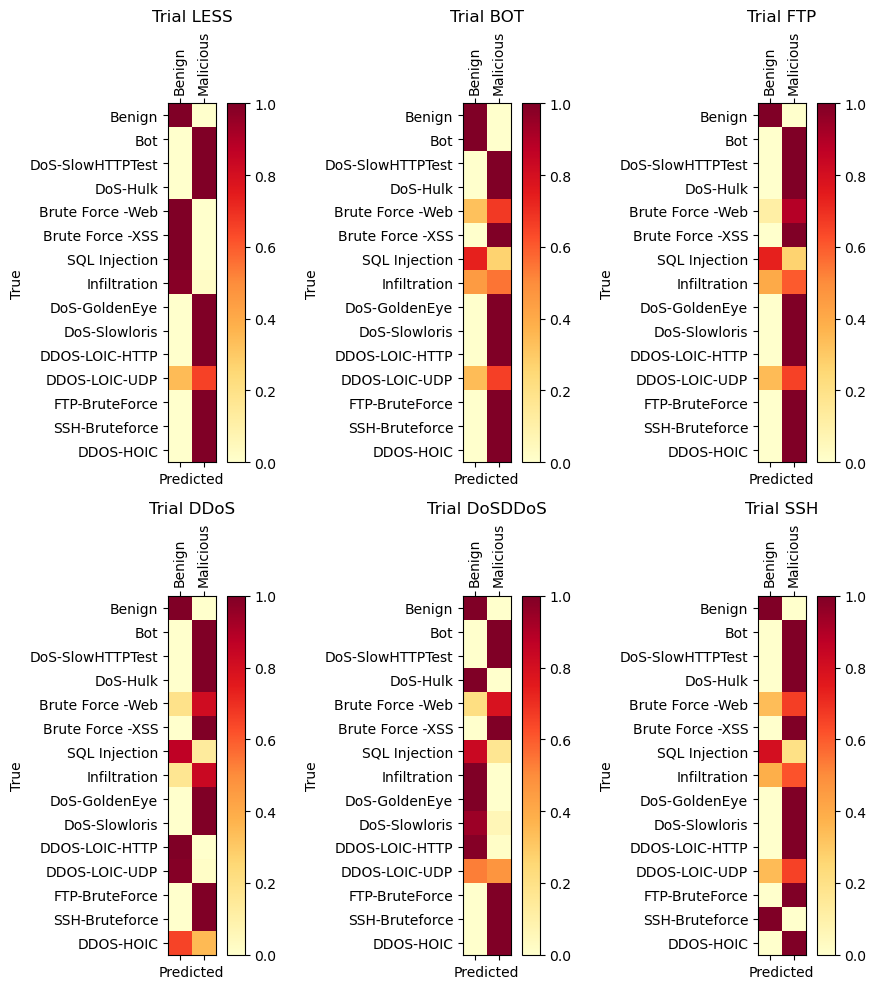

In [29]:
average_mlp_binary_confusion_matrix = {k: v.mean(axis=0) for k, v in mlp_binary_confusion_probabilities.items()}
plot_confusion_matrixies_binary(average_mlp_binary_confusion_matrix)

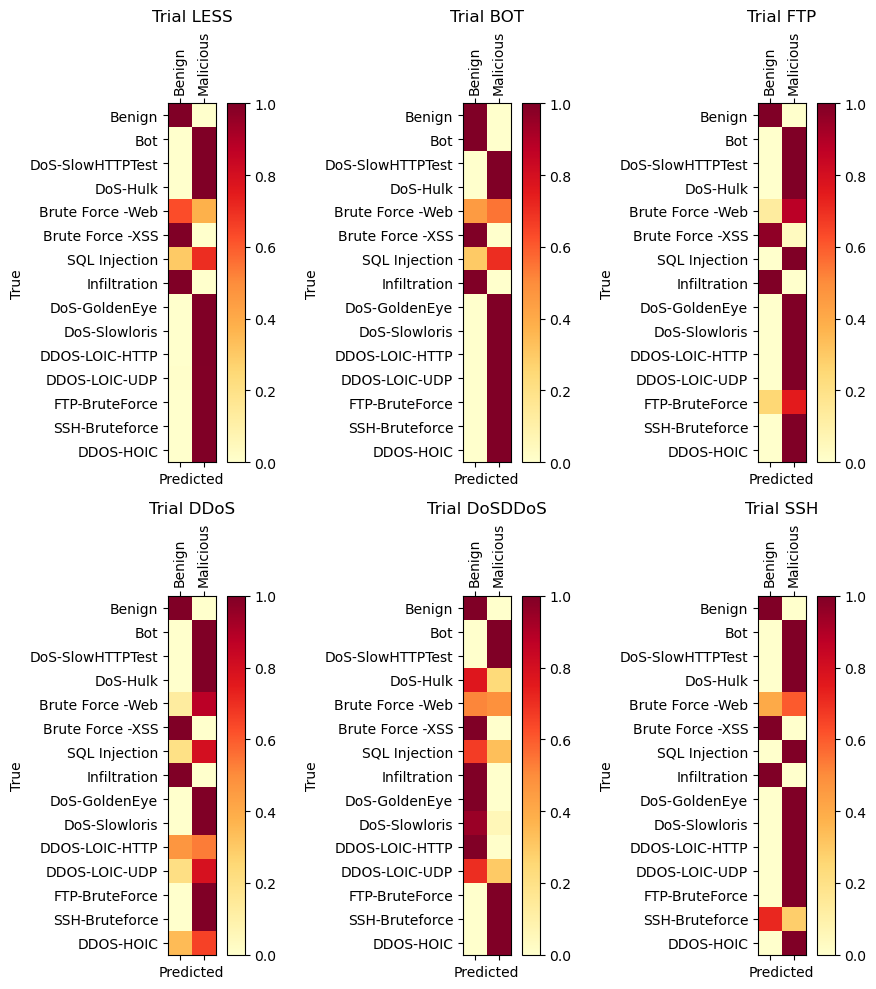

In [30]:
average_cids_binary_confusion_matrix = {k: v.mean(axis=0) for k, v in cids_binary_confusion_probabilities.items()}
plot_confusion_matrixies_binary(average_cids_binary_confusion_matrix)

### F1-Scores

As they are only few samples for Brute Force -Web, Brute Force -XSS, SQL Injection and Infiltration, we will remove them to not skew the data to much 

In [90]:
unsupervised = copy.deepcopy(unsupervised_leave_confusion_matrices)
unsupervised.pop("LESS")
unsupervised["BASE"] = unsupervised_confusion_matrices["MLPAE"]
unsupervised = remove_rows_binary(unsupervised, remove=[4, 5, 6, 7], avg=False)

mlp = copy.deepcopy(mlp_binary_confusion_matrices)
mlp.pop("LESS")
# mlp["BASE"] = mlp["MLPAE"]
mlp = remove_rows_binary(mlp, remove=[4, 5, 6, 7], avg=False)

cids = copy.deepcopy(cids_binary_confusion_matrices)
cids.pop("LESS")
# unsupervised["BASE"] = unsupervised_confusion_matrices["MLPAE"]
cids = remove_rows_binary(cids, remove=[4, 5, 6, 7], avg=False)


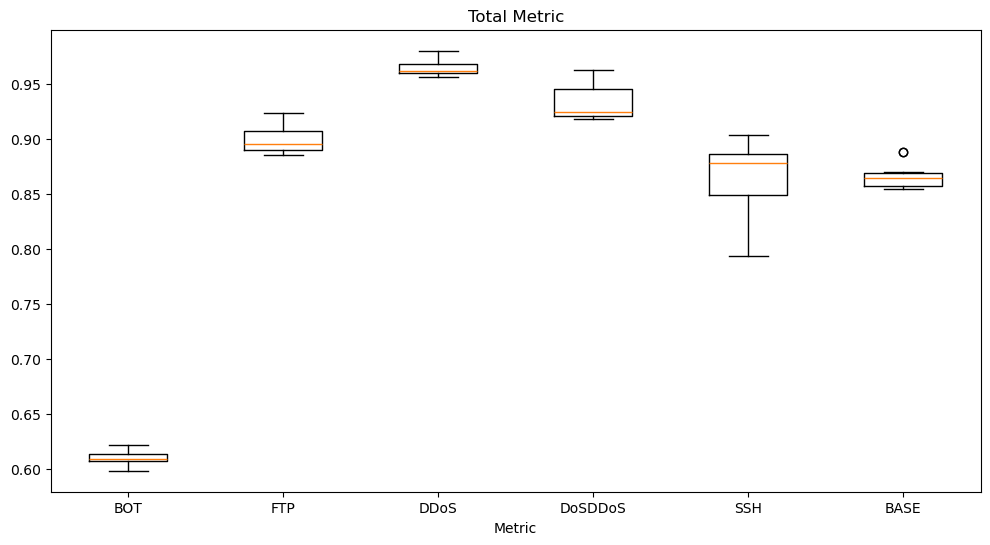

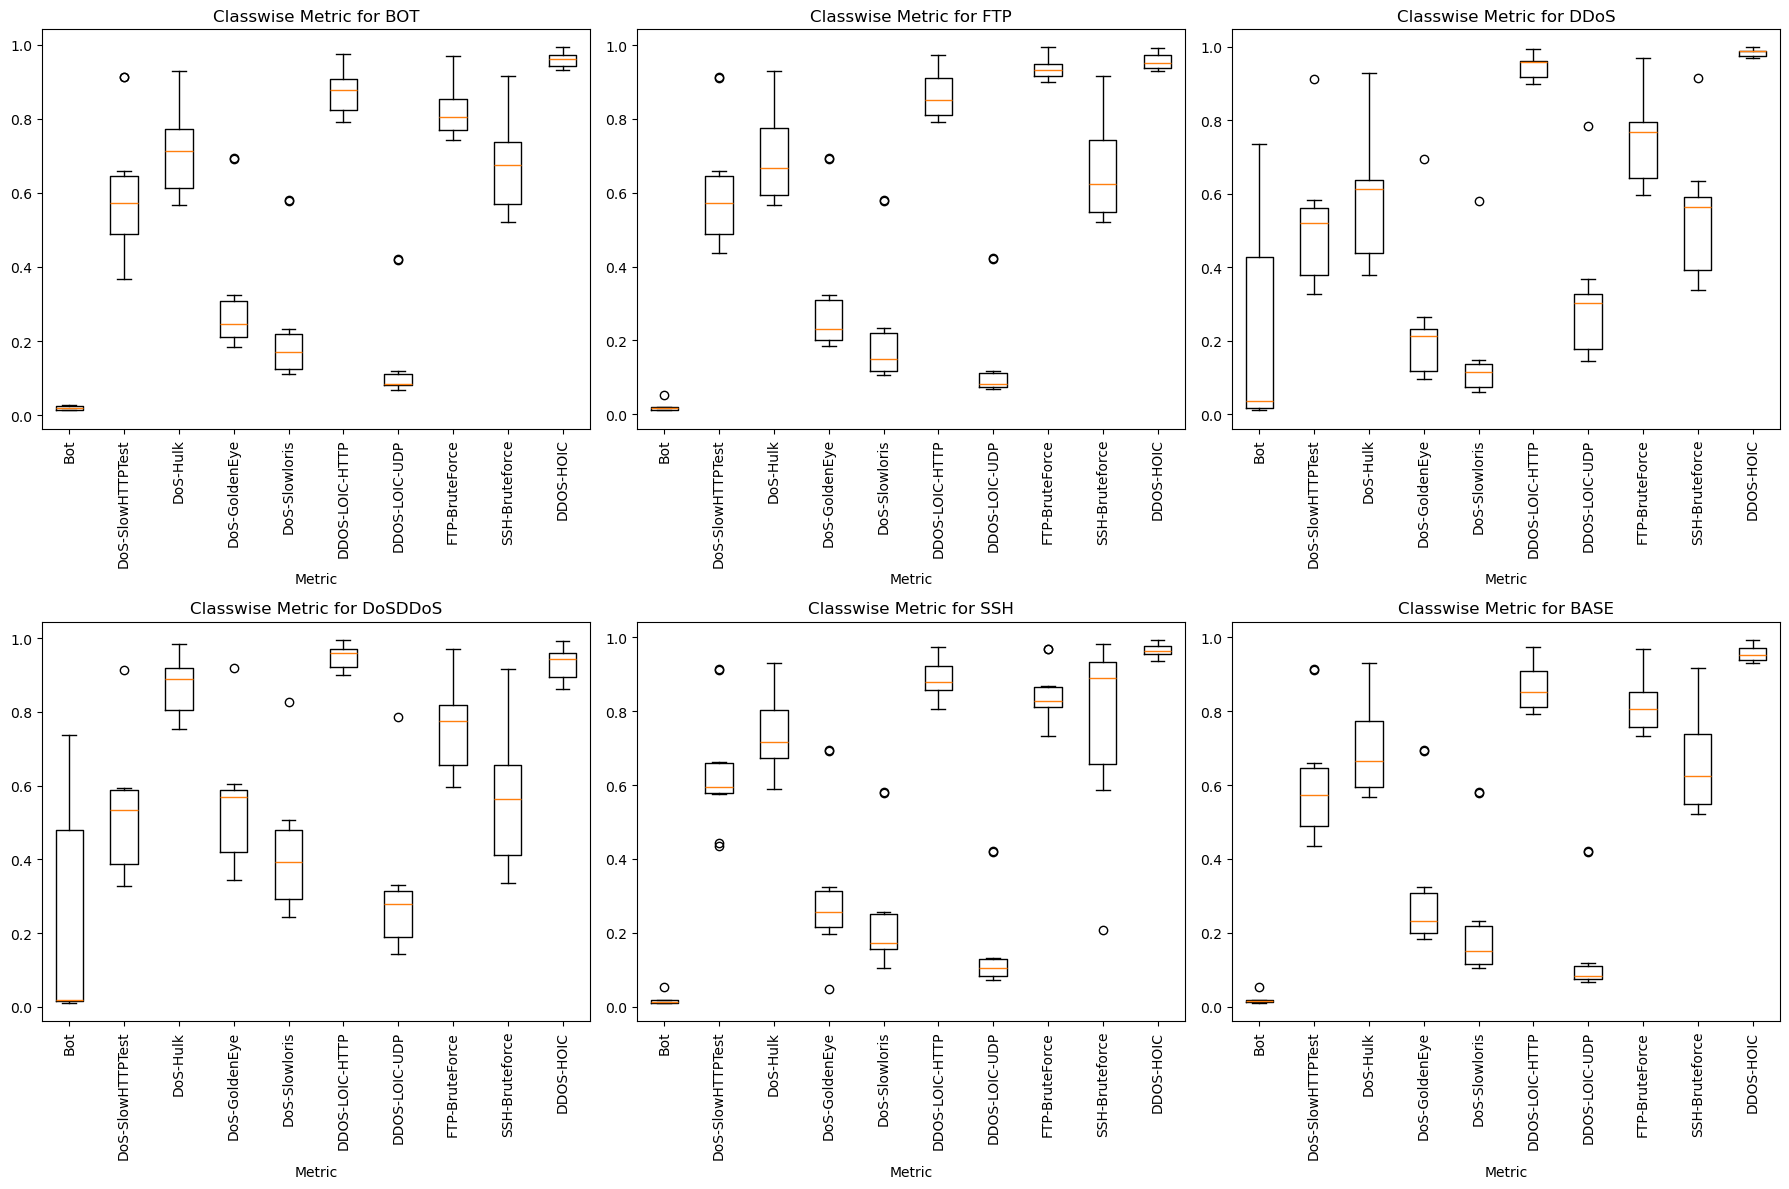

In [89]:
boxplot_metric(unsupervised, metric=classwise_f1_binary, labels=[cls for cls, v in SCVIC_CIDS_CLASSES.items() if v not in [0, 4, 5, 6, 7]])

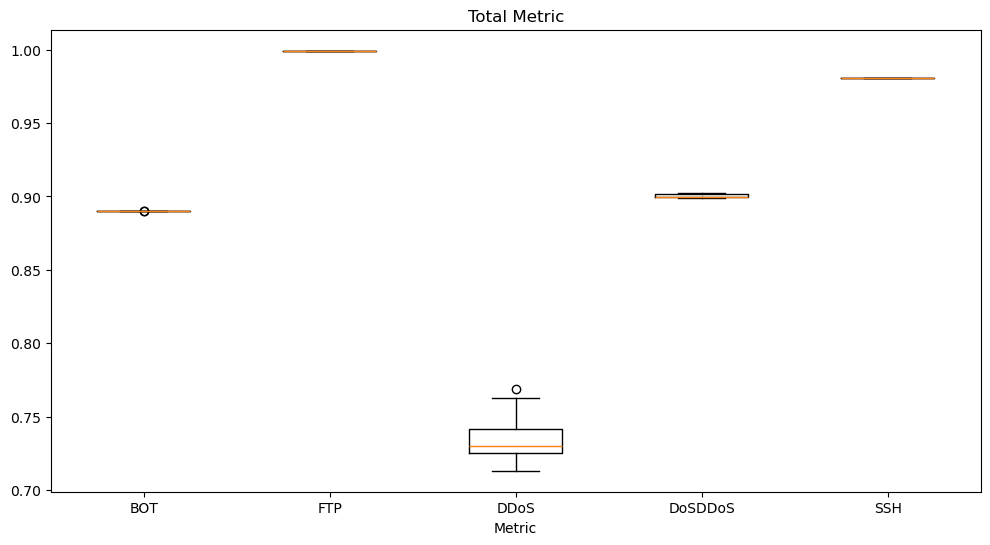

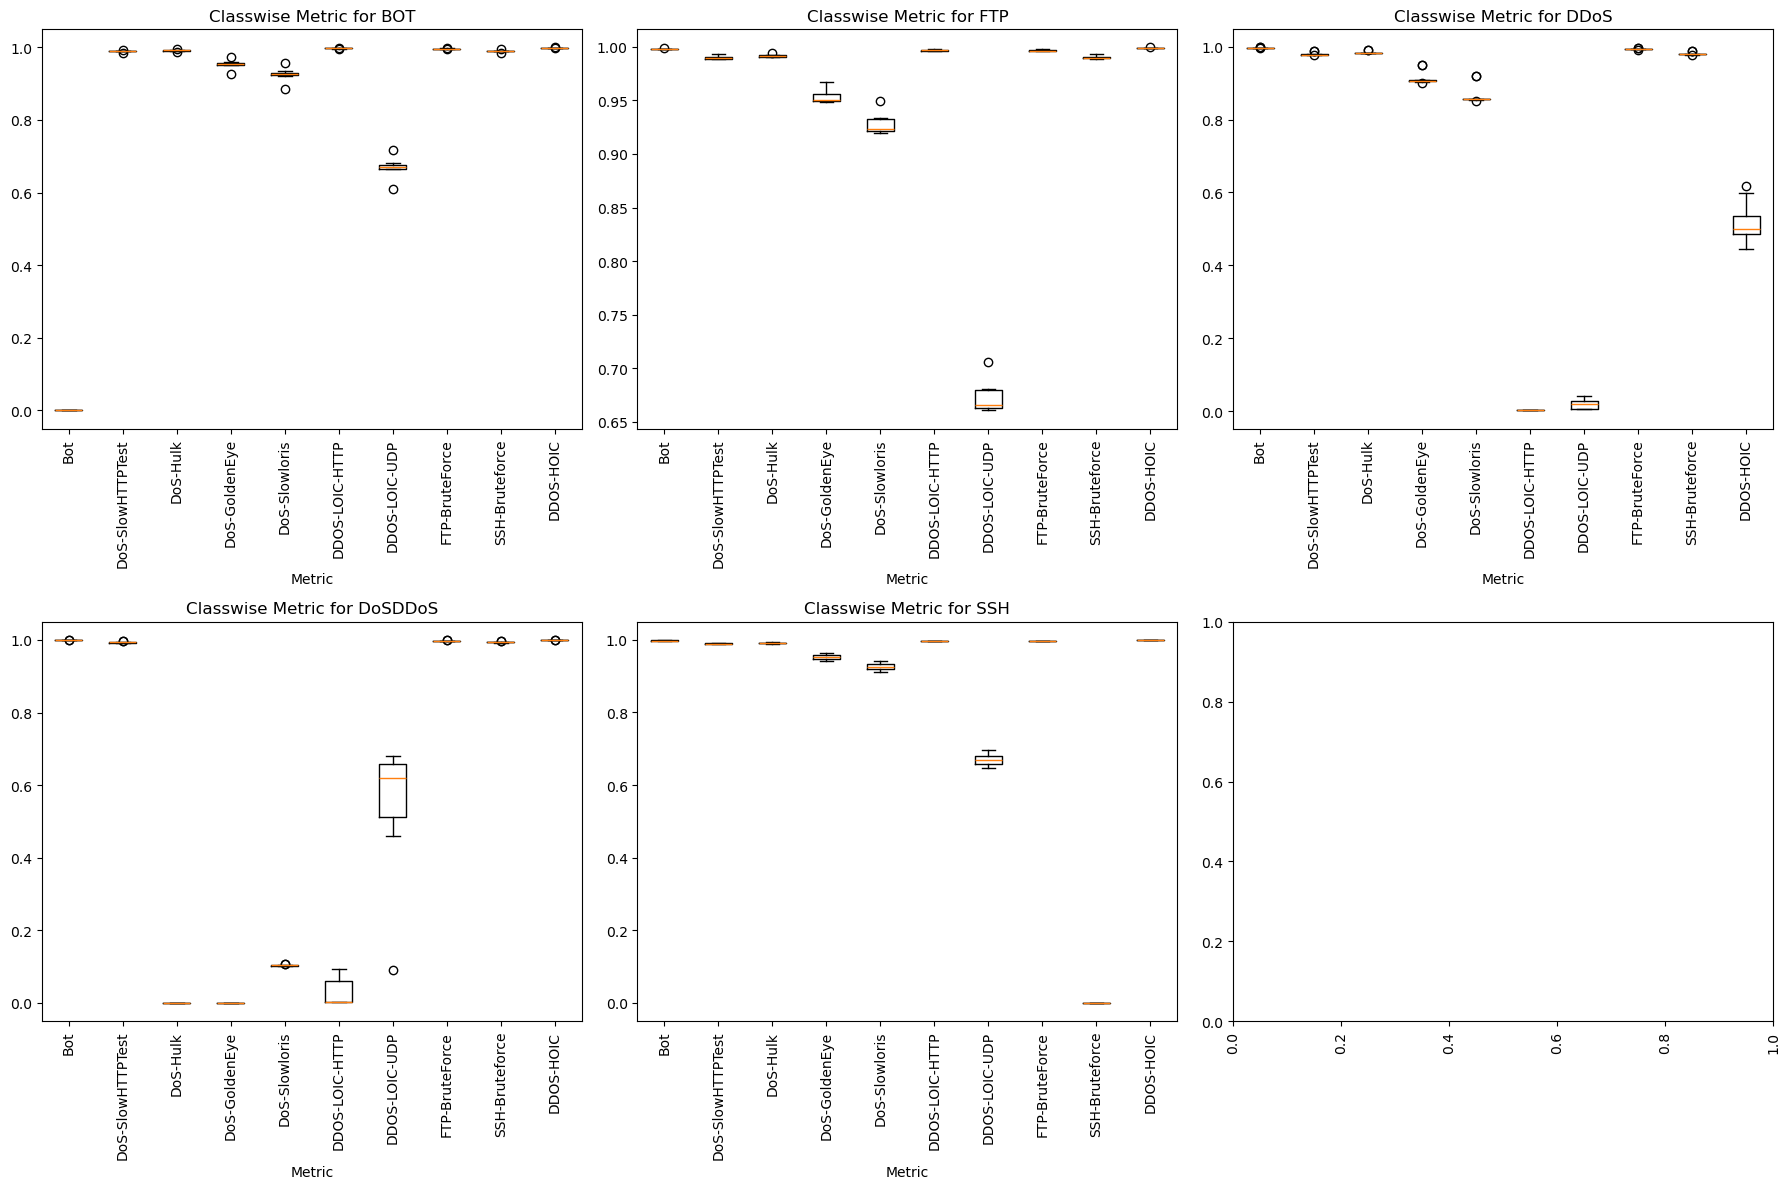

In [92]:
boxplot_metric(mlp, metric=classwise_f1_binary, labels=[cls for cls, v in SCVIC_CIDS_CLASSES.items() if v not in [0, 4, 5, 6, 7]])

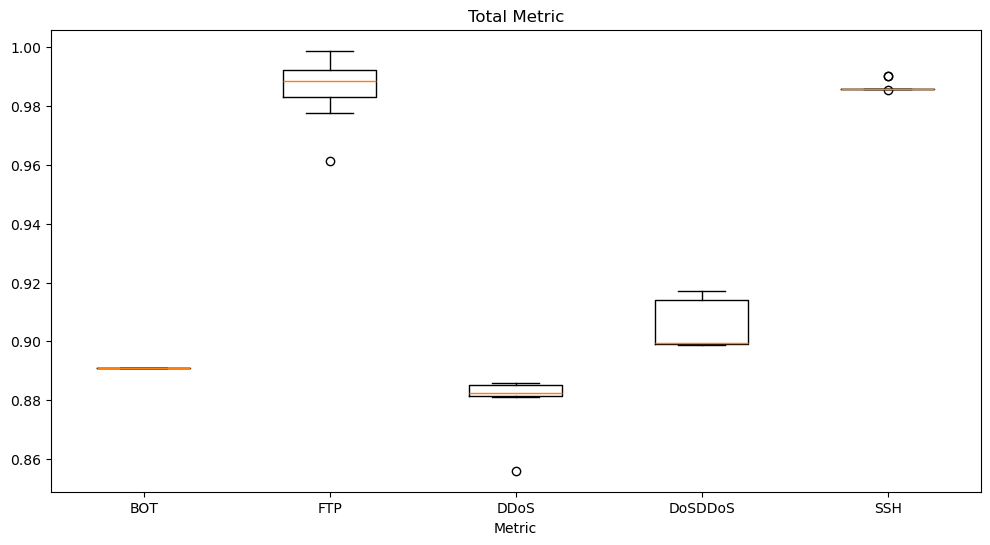

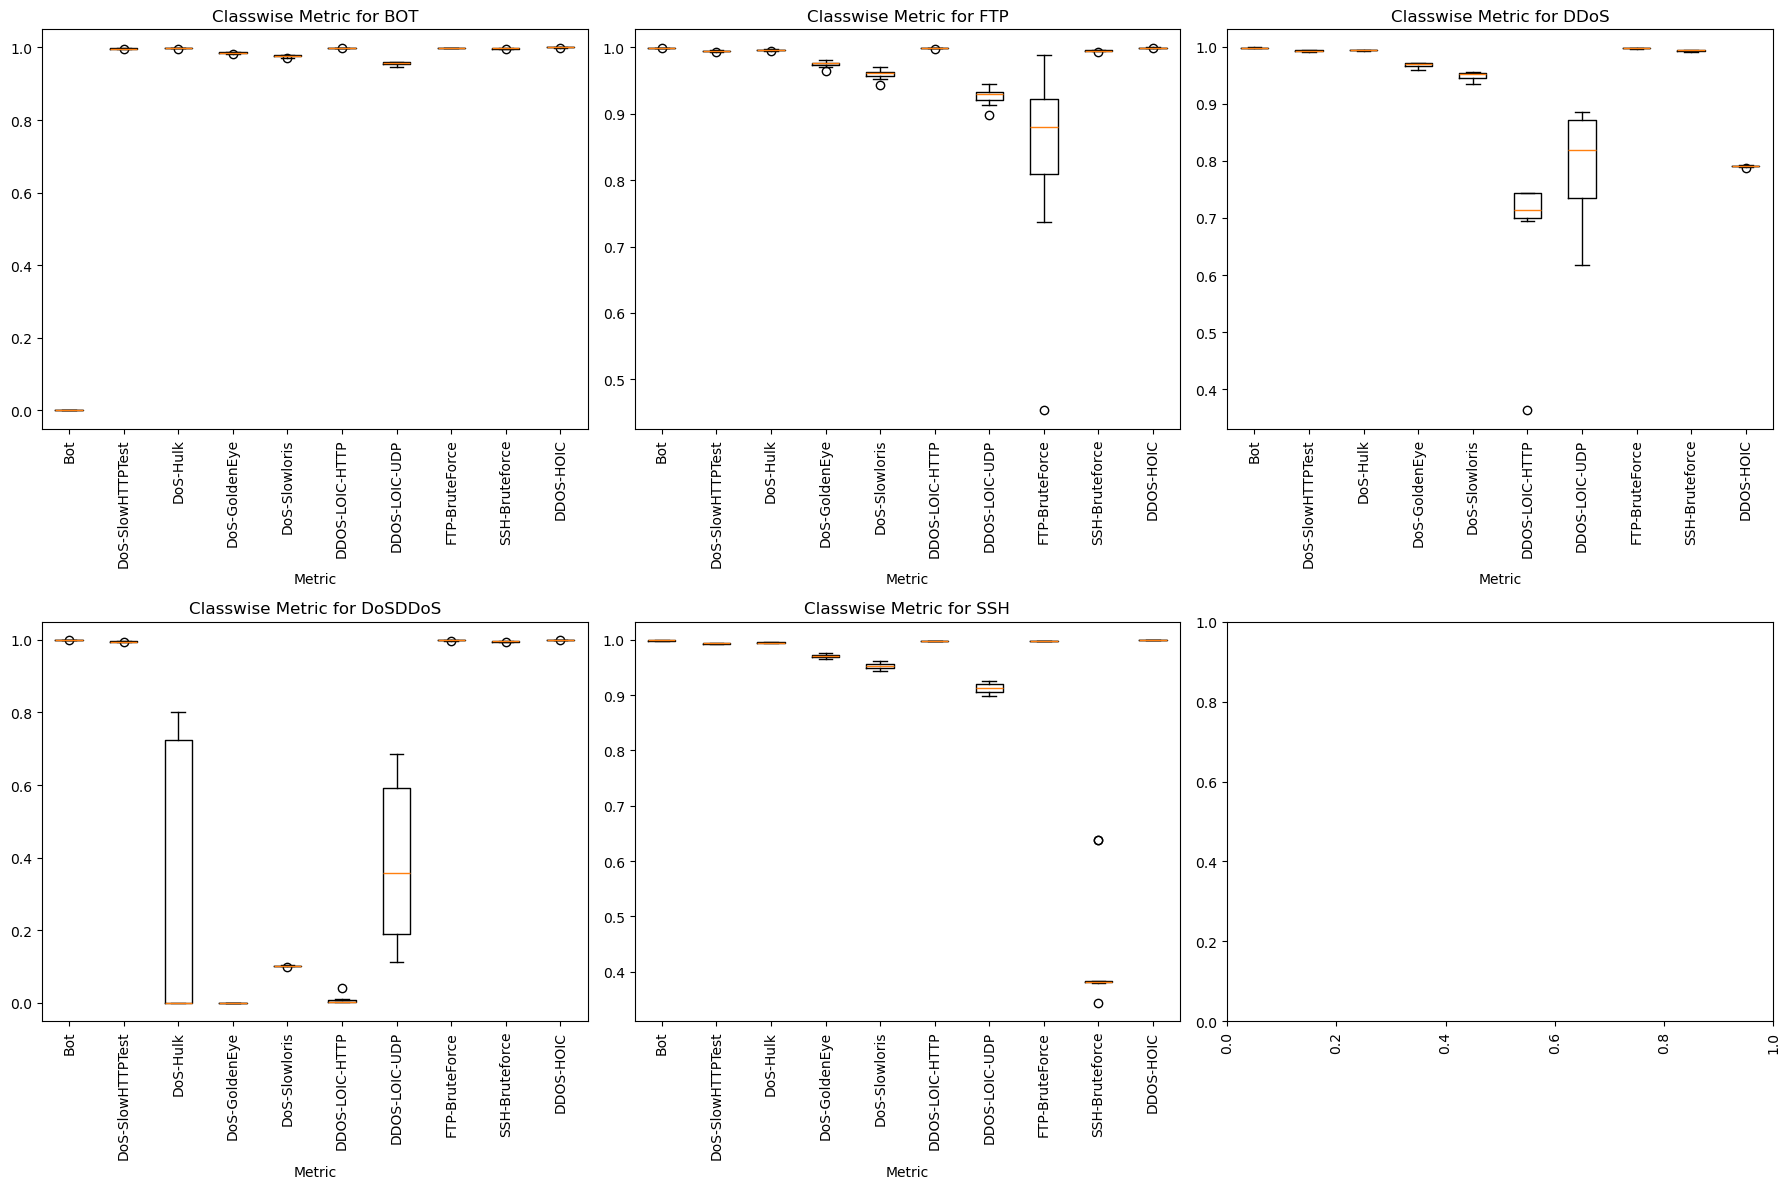

In [93]:
boxplot_metric(cids, metric=classwise_f1_binary, labels=[cls for cls, v in SCVIC_CIDS_CLASSES.items() if v not in [0, 4, 5, 6, 7]])